# **Загрузка данных и вспомогательные функции**

In [1]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
import matplotlib.pyplot as plt

In [2]:
def evaluate_accuracy(data_iter, net):
  acc_sum, n = 0, 0
  net.eval()
  for X, y in data_iter:
    X, y = X.to(device), y.to(device)
    acc_sum += (net(X).argmax(axis=1) == y).sum()
    n += y.shape[0]
  return acc_sum.item() / n

In [3]:
def train(net, train_iter, test_iter, trainer, num_epochs):
  net.to(device)
  loss_list = [] # список для значений функции потерь на трейне
  best_acc = 0 # переменная для лучшего значения accuracy
  loss = nn.CrossEntropyLoss(reduction = 'sum')
  net.train()
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

    for i, (X, y) in enumerate(train_iter):
      X, y = X.to(device), y.to(device)
      trainer.zero_grad()
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      trainer.step()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
      n += y.shape[0]

      if i % 100 == 0:
          print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")

    test_acc = evaluate_accuracy(test_iter, net.to(device))
    print(f'epoch {epoch + 1}, loss {train_l_sum / n}, train acc {train_acc_sum / n}, test acc {test_acc}, time {time.time() - start} sec')
    loss_list.append(train_l_sum / n)
    if test_acc > best_acc:
      best_acc = test_acc
  return loss_list, best_acc # будем возвращать список со значениями функции потерь на обучении и лучшую метрику на тесте

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    #lambda img: tv.transforms.functional.rotate(img, -90), # датасет почему-то был перевенутый и какой-то наклоненный, поэтому можно как вариант перевернуть все картинки,если будет плохая метрика
    #lambda img: tv.transforms.functional.hflip(img),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True) #balanced выбран по количеству данных
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:05<00:00, 108729715.85it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [6]:
# посмотрим, какие тут есть классы и сколько их
l = train_dataset.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)

No of classes:  47
List of all classes
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [7]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

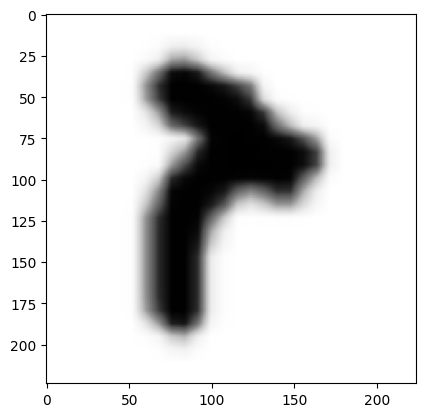

In [13]:
plt.imshow(train_dataset[0][0][0], cmap='Greys')

# **RESNET18**

In [29]:
model = tv.models.resnet18(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [30]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
model.fc # необходимо поменять последний слой, т.к. количество выходов тут 1000

Linear(in_features=512, out_features=1000, bias=True)

In [31]:
model.fc = nn.Linear(in_features=512, out_features=47) # у нас на выходе 47 классjd

In [32]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

Обучаем с нуля все слои

In [33]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [34]:
result_resnet = train(model, train_iter, test_iter, trainer, 10)

Step 0. time since epoch: 1.118. Train acc: 0.016. Train Loss: 3.945
Step 100. time since epoch: 112.858. Train acc: 0.693. Train Loss: 1.100
Step 200. time since epoch: 223.392. Train acc: 0.770. Train Loss: 0.774
Step 300. time since epoch: 335.154. Train acc: 0.800. Train Loss: 0.648
Step 400. time since epoch: 446.120. Train acc: 0.817. Train Loss: 0.578
epoch 1, loss 0.5592872849931109, train acc 0.8221631205673758, test acc 0.8670212765957447, time 522.8108761310577 sec
Step 0. time since epoch: 1.189. Train acc: 0.848. Train Loss: 0.380
Step 100. time since epoch: 106.318. Train acc: 0.038. Train Loss: 5.221
Step 200. time since epoch: 211.375. Train acc: 0.057. Train Loss: 4.366
Step 300. time since epoch: 316.522. Train acc: 0.143. Train Loss: 3.711
Step 400. time since epoch: 422.833. Train acc: 0.257. Train Loss: 3.117
epoch 2, loss 2.920964143901852, train acc 0.2974556737588652, test acc 0.7145212765957447, time 497.05745100975037 sec
Step 0. time since epoch: 1.033. Train

In [35]:
result_resnet

([0.5592872849931109,
  2.920964143901852,
  0.6084141113741178,
  0.4228865988372911,
  0.36219063826486575,
  0.32793642713668497,
  0.3052651993095452,
  0.2834788239594047,
  0.2682398555972052,
  0.2522743683672966],
 0.8892021276595745)

In [2]:
result_vgg = ([1.4432402907364756,
  0.34049793388826627,
  0.28274171714241625,
  0.24291649480238028,
  0.22057752693798524,
  0.19579807088730183,
  0.17573105779945428,
  0.16332276185353597,
  0.14855184362289753,
  0.13193407479752886],
 0.8895744680851064)

# **Inception V3**

Начиная с VGG 16 Google Colab перестал предоставлять необходимые для обучения модели ресурсы, поэтому VGG 16 обучалась отдельно на ресурсах Яндекса и представлена в дополнительном ноутбуке, а InceptionV3 удалось обучить только заморозив все слои, кроме последнего

In [33]:
model = tv.models.inception_v3(pretrained=True) # pretrained т.к. вычислительных мощностей уже не хватило для обучения модели с нуля
model = model.to(device)

In [34]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [35]:
for param in model.parameters():
    param.requires_grad = False

In [36]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [37]:
model.fc = nn.Linear(in_features=2048, out_features=47, bias=True)

In [38]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [39]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [40]:
# с ранее написанной функцией модель выдавала ошибки, поэтому пришлось внести изменения, взяв за основу отдельные решения других студентов
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        acc_sum += (y_hat.argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

def train(net, train_iter, test_iter, trainer, num_epochs):
    loss_list = []
    net.to(device)
    best_acc = 0
    loss = nn.CrossEntropyLoss(reduction='sum')
    #net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat[0].argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        loss_list.append(train_l_sum / n)
        if test_acc > best_acc:
          best_acc = test_acc
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return loss_list, best_acc

In [41]:
# т.к. модель обучалась на данных размерностью 299 на 299, необходимо было еще раз трансформировать данные под другой размер
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [42]:
result_inception = train(model, train_iter, test_iter, trainer, 10)

Step 0. time since epoch: 1.976. Train acc: 0.012. Train Loss: 3.930
Step 100. time since epoch: 183.239. Train acc: 0.322. Train Loss: 2.859
Step 200. time since epoch: 362.935. Train acc: 0.408. Train Loss: 2.428
Step 300. time since epoch: 542.718. Train acc: 0.452. Train Loss: 2.191
Step 400. time since epoch: 724.654. Train acc: 0.480. Train Loss: 2.039
--------------------
epoch 1, loss 1.9916, train acc 0.488, test acc 0.632, time 874.9 sec
Step 0. time since epoch: 1.733. Train acc: 0.578. Train Loss: 1.539
Step 100. time since epoch: 181.547. Train acc: 0.588. Train Loss: 1.452
Step 200. time since epoch: 363.010. Train acc: 0.593. Train Loss: 1.427
Step 300. time since epoch: 542.480. Train acc: 0.597. Train Loss: 1.411
Step 400. time since epoch: 723.754. Train acc: 0.599. Train Loss: 1.398
--------------------
epoch 2, loss 1.3933, train acc 0.599, test acc 0.670, time 875.2 sec
Step 0. time since epoch: 1.745. Train acc: 0.582. Train Loss: 1.452
Step 100. time since epoch:

In [43]:
result_inception

([1.9916463370357,
  1.3932827227166358,
  1.2944250921154699,
  1.246837187151537,
  1.228338222503662,
  1.2142893673511261,
  1.2062765113343583,
  1.197221033623878,
  1.1963272633112914,
  1.1863380768958558],
 0.7197872340425532)